In [1]:
#import all the necessary packages.

from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# import nltk
import math
import time
import re
import os
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances
from matplotlib import gridspec
from scipy.sparse import hstack
import plotly
import plotly.figure_factory as ff
from plotly.graph_objs import Scatter, Layout

plotly.offline.init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")

In [ ]:
data = pd.read_json('tops_fashion.json')


In [ ]:
print ('Number of data points : ', data.shape[0], \
       'Number of features/variables:', data.shape[1])
data.columns

In [ ]:
data = data[['asin', 'brand', 'color', 'medium_image_url', 'product_type_name', 'title', 'formatted_price']]
data.head() 

In [ ]:
print(data['product_type_name'].describe())
print(data['product_type_name'].unique())

In [ ]:
data.to_pickle('pickels/180k_apparel_data')
data = pd.read_pickle('pickels/180k_apparel_data')

# find number of products that have duplicate titles.
print(sum(data.duplicated('title')))

In [ ]:
data_sorted = data[data['title'].apply(lambda x: len(x.split())>4)]
print("After removal of products with short description:", data_sorted.shape[0])

In [ ]:
data_sorted.sort_values('title',inplace=True, ascending=False)

In [ ]:
indices = []
for i,row in data_sorted.iterrows():
    indices.append(i)

In [ ]:
import itertools
stage1_dedupe_asins = []
i = 0
j = 0
num_data_points = data_sorted.shape[0]
while i < num_data_points and j < num_data_points:
    
    previous_i = i

    # store the list of words of ith string in a, ex: a = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'X-Large']
    a = data['title'].loc[indices[i]].split()

    # search for the similar products sequentially 
    j = i+1
    while j < num_data_points:

        # store the list of words of jth string in b, ex: b = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'Small']
        b = data['title'].loc[indices[j]].split()

        # store the maximum length of two strings
        length = max(len(a), len(b))

        # count is used to store the number of words that are matched in both strings
        count  = 0

        # itertools.zip_longest(a,b): will map the corresponding words in both strings, it will appened None in case of unequal strings
        # example: a =['a', 'b', 'c', 'd']
        # b = ['a', 'b', 'd']
        # itertools.zip_longest(a,b): will give [('a','a'), ('b','b'), ('c','d'), ('d', None)]
        for k in itertools.zip_longest(a,b): 
            if (k[0] == k[1]):
                count += 1

        # if the number of words in which both strings differ are > 2 , we are considering it as those two apperals are different
        # if the number of words in which both strings differ are < 2 , we are considering it as those two apperals are same, hence we are ignoring them
        if (length - count) > 2: # number of words in which both sensences differ
            # if both strings are differ by more than 2 words we include the 1st string index
            stage1_dedupe_asins.append(data_sorted['asin'].loc[indices[i]])

            # if the comaprision between is between num_data_points, num_data_points-1 strings and they differ in more than 2 words we include both
            if j == num_data_points-1: stage1_dedupe_asins.append(data_sorted['asin'].loc[indices[j]])

            # start searching for similar apperals corresponds 2nd string
            i = j
            break
        else:
            j += 1
    if previous_i == i:
        break

In [ ]:
data = data.loc[data['asin'].isin(stage1_dedupe_asins)]

In [ ]:
print('Number of data points : ', data.shape[0])

Stage 2

In [ ]:
indices = []
tot=data.shape[0]
for i,row in data.iterrows():
    indices.append(i)
print("done")
stage2_dedupe_asins = []
ctr = 0

In [ ]:
while len(indices)!=0:
    
    for x in range(100):
        if math.floor((x/100)*tot) == ctr :
            print(x*10,"\n")

    ctr+=1    
    i = indices.pop()
    stage2_dedupe_asins.append(data['asin'].loc[i])
    # consider the first apperal's title
    a = data['title'].loc[i].split()
    # store the list of words of ith string in a, ex: a = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'X-Large']
    for j in indices:
        
        b = data['title'].loc[j].split()
        # store the list of words of jth string in b, ex: b = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'X-Large']
        
        length = max(len(a),len(a))
        
        # count is used to store the number of words that are matched in both strings
        count  = 0

        # itertools.zip_longest(a,b): will map the corresponding words in both strings, it will appened None in case of unequal strings
        # example: a =['a', 'b', 'c', 'd']
        # b = ['a', 'b', 'd']
        # itertools.zip_longest(a,b): will give [('a','a'), ('b','b'), ('c','d'), ('d', None)]
        for k in itertools.zip_longest(a,b): 
            if (k[0]==k[1]):
                count += 1

        # if the number of words in which both strings differ are < 3 , we are considering it as those two apperals are same, hence we are ignoring them
        if (length - count) < 3:
            indices.remove(j)

In [ ]:
data = data.loc[data['asin'].isin(stage2_dedupe_asins)]
print('Number of data points after stage two of dedupe: ',data.shape[0])


Text pre-processing

In [ ]:
stop_words = set(stopwords.words('english'))
print ('list of stop words:', stop_words)

def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        for words in total_text.split():
            # remove the special chars in review like '"#$@!%^&*()_+-~?>< etc.
            word = ("".join(e for e in words if e.isalnum()))
            # Conver all letters to lower-case
            word = word.lower()
            # stop-word removal
            if not word in stop_words:
                string += word + " "
        data[column][index] = string

In [ ]:
start_time = time.clock()
# we take each title and we text-preprocess it.
for index, row in data.iterrows():
    nlp_preprocessing(row['title'], index, 'title')
# we print the time it took to preprocess whole titles 
print(time.clock() - start_time, "seconds")

In [ ]:
# STEMMING
# NOT working

# from nltk.stem.porter import *
# stemmer = PorterStemmer()



Text based product similarity

In [2]:
data = pd.read_pickle('pickels/16k_apperal_data_preprocessed')
# Utility Functions which we will use through the rest of the workshop.


#Display an image
def display_img(url,ax,fig):
    # we get the url of the apparel and download it
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    # we will display it in notebook 
    plt.imshow(img)
  
#plotting code to understand the algorithm's decision.
def plot_heatmap(keys, values, labels, url, text):
        # keys: list of words of recommended title
        # values: len(values) ==  len(keys), values(i) represents the occurence of the word keys(i)
        # labels: len(labels) == len(keys), the values of labels depends on the model we are using
        # url : apparel's url

        # we will devide the whole figure into two parts
        gs = gridspec.GridSpec(2, 2, width_ratios=[4,1], height_ratios=[4,1]) 
        fig = plt.figure(figsize=(25,3))
        
        # 1st, ploting heat map that represents the count of commonly ocurred words in title2
        ax = plt.subplot(gs[0])
        # it displays a cell in white color if the word is intersection(lis of words of title1 and list of words of title2), in black if not
        ax = sns.heatmap(np.array([values]), annot=np.array([labels]))
        ax.set_xticklabels(keys) # set that axis labels as the words of title
        ax.set_title(text) # apparel title
        
        # 2nd, plotting image of the the apparel
        ax = plt.subplot(gs[1])
        # we don't want any grid lines for image and no labels on x-axis and y-axis
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        
        # we call dispaly_img based with paramete url
        display_img(url, ax, fig)
        
        # displays combine figure ( heat map and image together)
        plt.show()
    
def plot_heatmap_image(doc_id, vec1, vec2, url, text, model):

    # doc_id : index of the title1
    # vec1 : input apparels's vector, it is of a dict type {word:count}
    # vec2 : recommended apparels's vector, it is of a dict type {word:count}
    # url : apparels image url
    # text: title of recomonded apparel (used to keep title of image)
    # model, it can be any of the models, 
        # 1. bag_of_words
        # 2. tfidf
        # 3. idf

    # we find the common words in both titles, because these only words contribute to the distance between two title vec's
    intersection = set(vec1.keys()) & set(vec2.keys()) 

    # we set the values of non intersecting words to zero, this is just to show the difference in heatmap
    for i in vec2:
        if i not in intersection:
            vec2[i]=0

    # for labeling heatmap, keys contains list of all words in title2
    keys = list(vec2.keys())
    #  if ith word in intersection(lis of words of title1 and list of words of title2): values(i)=count of that word in title2 else values(i)=0 
    values = [vec2[x] for x in vec2.keys()]
    
    # labels: len(labels) == len(keys), the values of labels depends on the model we are using
        # if model == 'bag of words': labels(i) = values(i)
        # if model == 'tfidf weighted bag of words':labels(i) = tfidf(keys(i))
        # if model == 'idf weighted bag of words':labels(i) = idf(keys(i))

    if model == 'bag_of_words':
        labels = values
    elif model == 'tfidf':
        labels = []
        for x in vec2.keys():
            # tfidf_title_vectorizer.vocabulary_ it contains all the words in the corpus
            # tfidf_title_features[doc_id, index_of_word_in_corpus] will give the tfidf value of word in given document (doc_id)
            if x in  tfidf_title_vectorizer.vocabulary_:
                labels.append(tfidf_title_features[doc_id, tfidf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)
    elif model == 'idf':
        labels = []
        for x in vec2.keys():
            # idf_title_vectorizer.vocabulary_ it contains all the words in the corpus
            # idf_title_features[doc_id, index_of_word_in_corpus] will give the idf value of word in given document (doc_id)
            if x in  idf_title_vectorizer.vocabulary_:
                labels.append(idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)

    plot_heatmap(keys, values, labels, url, text)


# this function gets a list of wrods along with the frequency of each 
# word given "text"
def text_to_vector(text):
    word = re.compile(r'\w+')
    words = word.findall(text)
    # words stores list of all words in given string, you can try 'words = text.split()' this will also gives same result
    return Counter(words) # Counter counts the occurence of each word in list, it returns dict type object {word1:count}



def get_result(doc_id, content_a, content_b, url, model):
    text1 = content_a
    text2 = content_b
    
    # vector1 = dict{word11:#count, word12:#count, etc.}
    vector1 = text_to_vector(text1)

    # vector1 = dict{word21:#count, word22:#count, etc.}
    vector2 = text_to_vector(text2)

    plot_heatmap_image(doc_id, vector1, vector2, url, text2, model)

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
title_vectorizer = CountVectorizer()
title_features   = title_vectorizer.fit_transform(data['title'])
title_features.get_shape() # get number of rows and columns in feature matrix.
# title_features.shape = #data_points * #words_in_corpus
# CountVectorizer().fit_transform(corpus) returns 

# title_features[doc_id, index_of_word_in_corpus] = number of times the word occured in that doc



(16042, 12609)

BAG OF WORDS

In [5]:
def bag_of_words_model(doc_id, num_results):
    # doc_id: apparel's id in given corpus
    
    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    pairwise_dist = pairwise_distances(title_features,title_features[doc_id])
    
    # np.argsort will return indices of the smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])
    
    sum = 0
    for i in range(0,len(indices)):
        # we will pass 1. doc_id, 2. title1, 3. title2, url, model
#         get_result(indices[i],data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'bag_of_words')
#         print('ASIN :',data['asin'].loc[df_indices[i]])
#         print ('Brand:', data['brand'].loc[df_indices[i]])
#         print ('Title:', data['title'].loc[df_indices[i]])
        sum =  pdists[i] + sum
#         print ('Euclidean similarity with the query image :', pdists[i])
#         print('='*60)

    avg = sum/4
    return avg
#call the bag-of-words model for a product to get similar products.
a = bag_of_words_model(931, 5) # change the index if you want to.
print(a)
# In the output heat map each value represents the count value 
# of the label word, the color represents the intersection 
# with inputs title.

#try 12566
#try 931

3.4272324089421655


TF-IDF based product similarity

In [6]:
tfidf_title_vectorizer = TfidfVectorizer(min_df = 0)
tfidf_title_features = tfidf_title_vectorizer.fit_transform(data['title'])

In [7]:
def tfidf_model(doc_id, num_results):
    # doc_id: apparel's id in given corpus
    
    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    pairwise_dist = pairwise_distances(tfidf_title_features,tfidf_title_features[doc_id])

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])

    sum = 0
    
    for i in range(0,len(indices)):
        # we will pass 1. doc_id, 2. title1, 3. title2, url, model
#         get_result(indices[i], data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'tfidf')
#         print('ASIN :',data['asin'].loc[df_indices[i]])
#         print('BRAND :',data['brand'].loc[df_indices[i]])
        sum = sum + pdists[i]
#         print ('Eucliden distance from the given image :', pdists[i])
#         print('='*120)
    avg = sum/4
    return avg

print(tfidf_model(12566, 5))
# in the output heat map each value represents the tfidf values of the label word, the color represents the intersection with inputs title

0.9120219748722642


IDF based product similarity

In [8]:
idf_title_vectorizer = CountVectorizer()
idf_title_features = idf_title_vectorizer.fit_transform(data['title'])

def n_containing(word):
    # return the number of documents which had the given word
    return sum(1 for blob in data['title'] if word in blob.split())

def idf(word):
    # idf = log(#number of docs / #number of docs which had the given word)
    return math.log(data.shape[0] / (n_containing(word)))

In [9]:
# we need to convert the values into float
idf_title_features  = idf_title_features.astype(np.float)

for i in idf_title_vectorizer.vocabulary_.keys():
    # for every word in whole corpus we will find its idf value
    idf_val = idf(i)
    
    # to calculate idf_title_features we need to replace the count values with the idf values of the word
    # idf_title_features[:, idf_title_vectorizer.vocabulary_[i]].nonzero()[0] will return all documents in which the word i present
    for j in idf_title_features[:, idf_title_vectorizer.vocabulary_[i]].nonzero()[0]:
        
        # we replace the count values of word i in document j with  idf_value of word i 
        # idf_title_features[doc_id, index_of_word_in_courpus] = idf value of word
        idf_title_features[j,idf_title_vectorizer.vocabulary_[i]] = idf_val

In [11]:
def idf_model(doc_id, num_results):
    # doc_id: apparel's id in given corpus
    
    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    pairwise_dist = pairwise_distances(idf_title_features,idf_title_features[doc_id])

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])

    sum = 0
    for i in range(0,len(indices)):
#         get_result(indices[i],data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'idf')
#         print('ASIN :',data['asin'].loc[df_indices[i]])
#         print('Brand :',data['brand'].loc[df_indices[i]])
        sum = sum + pdists[i]
#         print ('euclidean distance from the given image :', pdists[i])
#         print('='*120)
    avg = sum/4
    return avg
        
print(idf_model(12566,5))
# in the output heat map each value represents the idf values of the label word, the color represents the intersection with inputs title

13.998414972069277


Text Semantics based product similarity

In [12]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)


# or use this
with open('word2vec_model', 'rb') as handle:
    model = pickle.load(handle)


unable to import 'smart_open.gcs', disabling that module


In [13]:
# Utility functions

def get_word_vec(sentence, doc_id, m_name):
    # sentence : title of the apparel
    # doc_id: document id in our corpus
    # m_name: model information it will take two values
        # if  m_name == 'avg', we will append the model[i], w2v representation of word i
        # if m_name == 'weighted', we will multiply each w2v[word] with the idf(word)
    vec = []
    for i in sentence.split():
        if i in vocab:
            if m_name == 'weighted' and i in  idf_title_vectorizer.vocabulary_:
                vec.append(idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[i]] * model[i])
            elif m_name == 'avg':
                vec.append(model[i])
        else:
            # if the word in our courpus is not there in the google word2vec corpus, we are just ignoring it
            vec.append(np.zeros(shape=(300,)))
    # we will return a numpy array of shape (#number of words in title * 300 ) 300 = len(w2v_model[word])
    # each row represents the word2vec representation of each word (weighted/avg) in given sentance 
    return  np.array(vec)

def get_distance(vec1, vec2):
    # vec1 = np.array(#number_of_words_title1 * 300), each row is a vector of length 300 corresponds to each word in give title
    # vec2 = np.array(#number_of_words_title2 * 300), each row is a vector of length 300 corresponds to each word in give title
    
    final_dist = []
    # for each vector in vec1 we caluclate the distance(euclidean) to all vectors in vec2
    for i in vec1:
        dist = []
        for j in vec2:
            # np.linalg.norm(i-j) will result the euclidean distance between vectors i, j
            dist.append(np.linalg.norm(i-j))
        final_dist.append(np.array(dist))
    # final_dist = np.array(#number of words in title1 * #number of words in title2)
    # final_dist[i,j] = euclidean distance between vectors i, j
    return np.array(final_dist)


def heat_map_w2v(sentence1, sentence2, url, doc_id1, doc_id2, model):
    # sentance1 : title1, input apparel
    # sentance2 : title2, recommended apparel
    # url: apparel image url
    # doc_id1: document id of input apparel
    # doc_id2: document id of recommended apparel
    # model: it can have two values, 1. avg 2. weighted
    
    #s1_vec = np.array(#number_of_words_title1 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s1_vec = get_word_vec(sentence1, doc_id1, model)
    #s2_vec = np.array(#number_of_words_title1 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s2_vec = get_word_vec(sentence2, doc_id2, model)

    # s1_s2_dist = np.array(#number of words in title1 * #number of words in title2)
    # s1_s2_dist[i,j] = euclidean distance between words i, j
    s1_s2_dist = get_distance(s1_vec, s2_vec)

    
    
    # devide whole figure into 2 parts 1st part displays heatmap 2nd part displays image of apparel
    gs = gridspec.GridSpec(2, 2, width_ratios=[4,1],height_ratios=[2,1]) 
    fig = plt.figure(figsize=(15,15))
    
    ax = plt.subplot(gs[0])
    # ploting the heap map based on the pairwise distances
    ax = sns.heatmap(np.round(s1_s2_dist,4), annot=True)
    # set the x axis labels as recommended apparels title
    ax.set_xticklabels(sentence2.split())
    # set the y axis labels as input apparels title
    ax.set_yticklabels(sentence1.split())
    # set title as recommended apparels title
    ax.set_title(sentence2)
    
    ax = plt.subplot(gs[1])
    # we remove all grids and axis labels for image
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    display_img(url, ax, fig)
    
    plt.show()

In [14]:
# vocab = stores all the words that are there in google w2v model
# vocab = model.wv.vocab.keys() # if you are using Google word2Vec

vocab = model.keys()
# this function will add the vectors of each word and returns the avg vector of given sentance
def build_avg_vec(sentence, num_features, doc_id, m_name):
    # sentace: its title of the apparel
    # num_features: the lenght of word2vec vector, its values = 300
    # m_name: model information it will take two values
        # if  m_name == 'avg', we will append the model[i], w2v representation of word i
        # if m_name == 'weighted', we will multiply each w2v[word] with the idf(word)

    featureVec = np.zeros((num_features,), dtype="float32")
    # we will intialize a vector of size 300 with all zeros
    # we add each word2vec(wordi) to this fetureVec
    nwords = 0
    
    for word in sentence.split():
        nwords += 1
        if word in vocab:
            if m_name == 'weighted' and word in  idf_title_vectorizer.vocabulary_:
                featureVec = np.add(featureVec, idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[word]] * model[word])
            elif m_name == 'avg':
                featureVec = np.add(featureVec, model[word])
    if(nwords>0):
        featureVec = np.divide(featureVec, nwords)
    # returns the avg vector of given sentance, its of shape (1, 300)
    return featureVec

Average Word2Vec product similarity.

In [15]:
doc_id = 0
w2v_title = []
# for every title we build a avg vector representation
for i in data['title']:
    w2v_title.append(build_avg_vec(i, 300, doc_id,'avg'))
    doc_id += 1

# w2v_title = np.array(# number of doc in courpus * 300), each row corresponds to a doc 
w2v_title = np.array(w2v_title)

In [ ]:
def avg_w2v_model(doc_id, num_results):
    # doc_id: apparel's id in given corpus
    
    # dist(x, y) = sqrt(dot(x, x) - 2 * dot(x, y) + dot(y, y))
    pairwise_dist = pairwise_distances(w2v_title, w2v_title[doc_id].reshape(1,-1))

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])
    
    sum=0
    for i in range(0, len(indices)):
#         heat_map_w2v(data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], indices[0], indices[i], 'avg')
#         print('ASIN :',data['asin'].loc[df_indices[i]])
#         print('BRAND :',data['brand'].loc[df_indices[i]])
        sum = sum + pdists[i]
#         print ('euclidean distance from given input image :', pdists[i])
#         print('='*120)
    
    return (sum/4)

        
print(avg_w2v_model(12566, 5))
# in the give heat map, each cell contains the euclidean distance between words i, j

IDF weighted Word2Vec for product similarity

In [17]:
doc_id = 0
w2v_title_weight = []
# for every title we build a weighted vector representation
for i in data['title']:
    w2v_title_weight.append(build_avg_vec(i, 300, doc_id,'weighted'))
    doc_id += 1
# w2v_title = np.array(# number of doc in courpus * 300), each row corresponds to a doc 
w2v_title_weight = np.array(w2v_title_weight)

In [18]:
def weighted_w2v_model(doc_id, num_results):
    # doc_id: apparel's id in given corpus
    
    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    pairwise_dist = pairwise_distances(w2v_title_weight, w2v_title_weight[doc_id].reshape(1,-1))

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])
    sum=0
    
    for i in range(0, len(indices)):
#         heat_map_w2v(data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], indices[0], indices[i], 'weighted')
#         print('ASIN :',data['asin'].loc[df_indices[i]])
#         print('Brand :',data['brand'].loc[df_indices[i]])
#         print('euclidean distance from input :', pdists[i])
        sum = sum + pdists[i]
#         print('='*120)
    return (sum/4)

print(weighted_w2v_model(12566, 5))
#931
#12566
# in the give heat map, each cell contains the euclidean distance between words i, j

4.97112774848938


Weighted similarity using brand and color.

In [19]:
# some of the brand values are empty. 
# Need to replace Null with string "NULL"
data['brand'].fillna(value="Not given", inplace=True )

# replace spaces with hypen
brands = [x.replace(" ", "-") for x in data['brand'].values]
types = [x.replace(" ", "-") for x in data['product_type_name'].values]
colors = [x.replace(" ", "-") for x in data['color'].values]

brand_vectorizer = CountVectorizer()
brand_features = brand_vectorizer.fit_transform(brands)

type_vectorizer = CountVectorizer()
type_features = type_vectorizer.fit_transform(types)

color_vectorizer = CountVectorizer()
color_features = color_vectorizer.fit_transform(colors)

extra_features = hstack((brand_features, type_features, color_features)).tocsr()

In [20]:
def heat_map_w2v_brand(sentance1, sentance2, url, doc_id1, doc_id2, df_id1, df_id2, model):
    
    # sentance1 : title1, input apparel
    # sentance2 : title2, recommended apparel
    # url: apparel image url
    # doc_id1: document id of input apparel
    # doc_id2: document id of recommended apparel
    # df_id1: index of document1 in the data frame
    # df_id2: index of document2 in the data frame
    # model: it can have two values, 1. avg 2. weighted
    
    #s1_vec = np.array(#number_of_words_title1 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s1_vec = get_word_vec(sentance1, doc_id1, model)
    #s2_vec = np.array(#number_of_words_title2 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s2_vec = get_word_vec(sentance2, doc_id2, model)
    
    # s1_s2_dist = np.array(#number of words in title1 * #number of words in title2)
    # s1_s2_dist[i,j] = euclidean distance between words i, j
    s1_s2_dist = get_distance(s1_vec, s2_vec)
   
    data_matrix = [['Asin','Brand', 'Color', 'Product type'],
               [data['asin'].loc[df_id1],brands[doc_id1], colors[doc_id1], types[doc_id1]], # input apparel's features
               [data['asin'].loc[df_id2],brands[doc_id2], colors[doc_id2], types[doc_id2]]] # recommonded apparel's features
    
    colorscale = [[0, '#1d004d'],[.5, '#f2e5ff'],[1, '#f2e5d1']] # to color the headings of each column 
    
    # we create a table with the data_matrix
    table = ff.create_table(data_matrix, index=True, colorscale=colorscale)
    # plot it with plotly
    plotly.offline.iplot(table, filename='simple_table')
    
    # devide whole figure space into 25 * 1:10 grids
    gs = gridspec.GridSpec(25, 15)
    fig = plt.figure(figsize=(25,5))
    
    # in first 25*10 grids we plot heatmap
    ax1 = plt.subplot(gs[:, :-5])
    # ploting the heap map based on the pairwise distances
    ax1 = sns.heatmap(np.round(s1_s2_dist,6), annot=True)
    # set the x axis labels as recommended apparels title
    ax1.set_xticklabels(sentance2.split())
    # set the y axis labels as input apparels title
    ax1.set_yticklabels(sentance1.split())
    # set title as recommended apparels title
    ax1.set_title(sentance2)

    # in last 25 * 10:15 grids we display image
    ax2 = plt.subplot(gs[:, 10:16])
    # we dont display grid lins and axis labels to images
    ax2.grid(False)
    ax2.set_xticks([])
    ax2.set_yticks([])
    
    # pass the url it display it
    display_img(url, ax2, fig)
    
    plt.show()

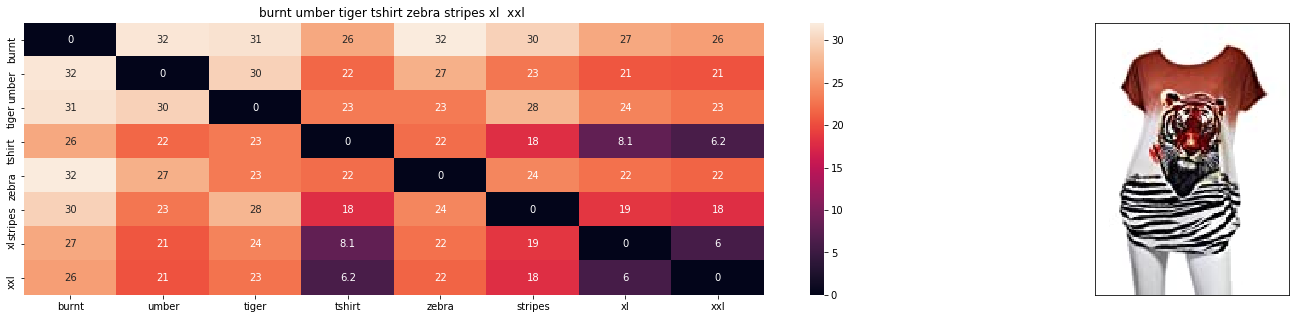

ASIN : B00JXQB5FQ
Brand : Si Row
euclidean distance from input : 0.0


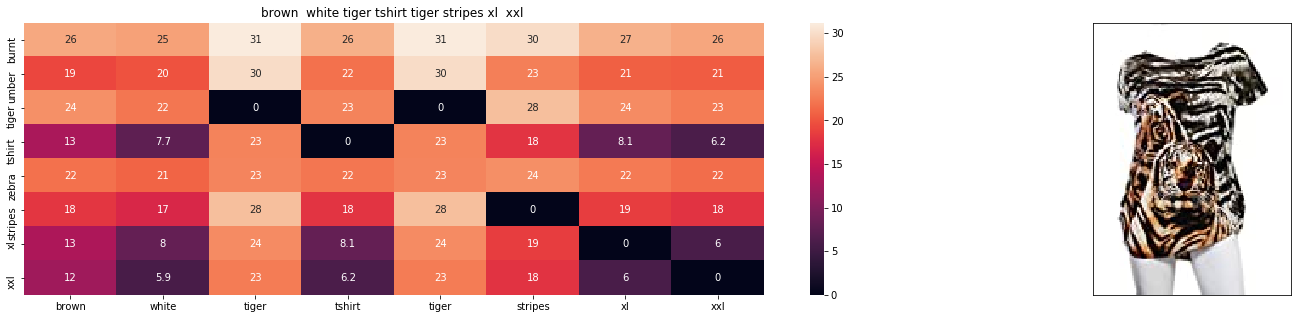

ASIN : B00JXQCWTO
Brand : Si Row
euclidean distance from input : 2.9818382263183594


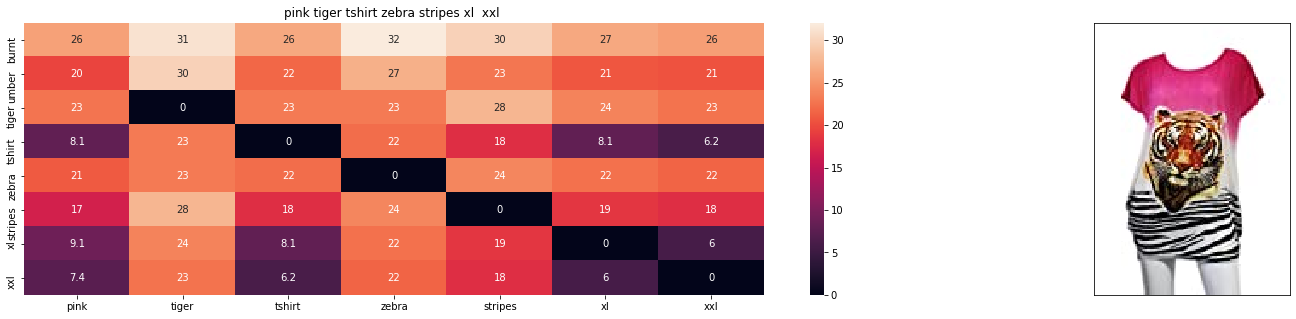

ASIN : B00JXQASS6
Brand : Si Row
euclidean distance from input : 3.0702592374249447


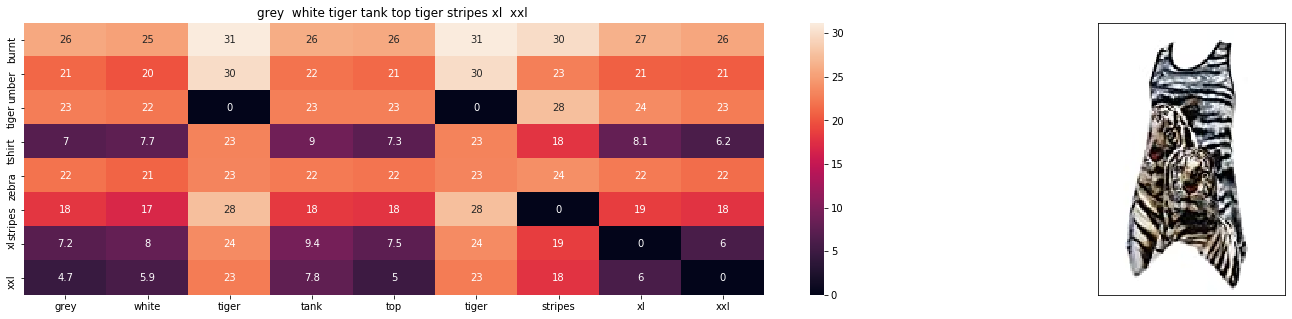

ASIN : B00JXQAFZ2
Brand : Si Row
euclidean distance from input : 3.8804303647442806


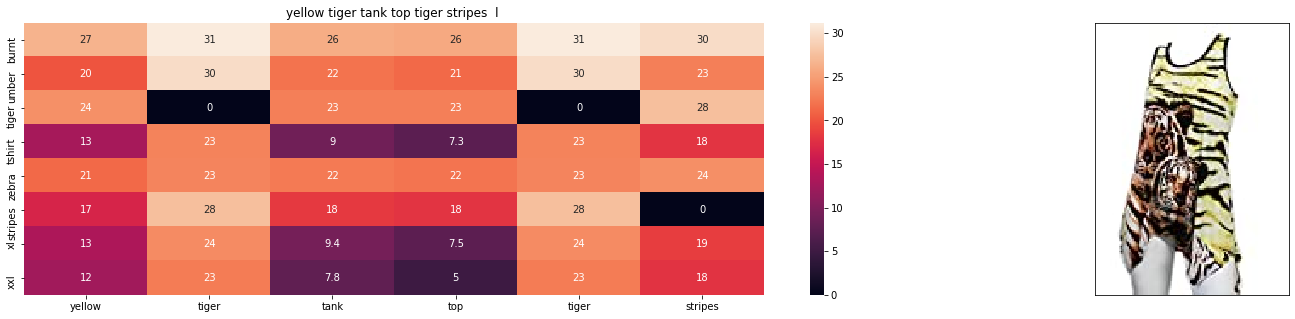

ASIN : B00JXQAUWA
Brand : Si Row
euclidean distance from input : 4.086281681196307


In [21]:
def idf_w2v_brand(doc_id, w1, w2, num_results):
    # doc_id: apparel's id in given corpus
    # w1: weight for  w2v features
    # w2: weight for brand and color features

    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    idf_w2v_dist  = pairwise_distances(w2v_title_weight, w2v_title_weight[doc_id].reshape(1,-1))
    ex_feat_dist = pairwise_distances(extra_features, extra_features[doc_id])
    pairwise_dist   = (w1 * idf_w2v_dist +  w2 * ex_feat_dist)/float(w1 + w2)

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])
    

    for i in range(0, len(indices)):
        heat_map_w2v_brand(data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], indices[0], indices[i],df_indices[0], df_indices[i], 'weighted')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('Brand :',data['brand'].loc[df_indices[i]])
        print('euclidean distance from input :', pdists[i])
        print('='*100)

idf_w2v_brand(12566, 5, 3, 5)
# in the give heat map, each cell contains the euclidean distance between words i, j

In [ ]:
# brand and color weight =50
# title vector weight = 5

idf_w2v_brand(12566, 5, 50, 5)

Keras and Tensorflow to extract features

In [90]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import requests
from PIL import Image
import pandas as pd
import pickle

Using TensorFlow backend.


In [ ]:
'''
# dimensions of our images.
img_width, img_height = 224, 224

top_model_weights_path = 'bottleneck_fc_model.h5'
train_data_dir = 'images2/'
nb_train_samples = 16042
epochs = 50
batch_size = 1


def save_bottlebeck_features():
    
    #Function to compute VGG-16 CNN for image feature extraction.
    
    asins = []
    datagen = ImageDataGenerator(rescale=1. / 255)
    
    # build the VGG16 network
    model = applications.VGG16(include_top=False, weights='imagenet')
    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

    for i in generator.filenames:
        asins.append(i[2:-5])

    bottleneck_features_train = model.predict_generator(generator, nb_train_samples // batch_size)
    bottleneck_features_train = bottleneck_features_train.reshape((16042,25088))
    
    np.save(open('16k_data_cnn_features.npy', 'wb'), bottleneck_features_train)
    np.save(open('16k_data_cnn_feature_asins.npy', 'wb'), np.array(asins))
    

save_bottlebeck_features()

'''

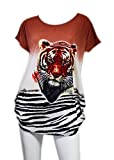

Product Title:  burnt umber tiger tshirt zebra stripes xl  xxl 
Euclidean Distance from input image: 6.32596e-06
Amazon Url: www.amzon.com/dp/B00JXQB5FQ


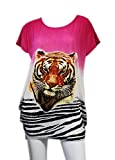

Product Title:  pink tiger tshirt zebra stripes xl  xxl 
Euclidean Distance from input image: 30.05017
Amazon Url: www.amzon.com/dp/B00JXQASS6


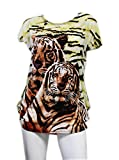

Product Title:  yellow tiger tshirt tiger stripes  l 
Euclidean Distance from input image: 41.261116
Amazon Url: www.amzon.com/dp/B00JXQCUIC


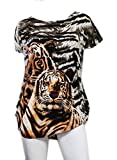

Product Title:  brown  white tiger tshirt tiger stripes xl  xxl 
Euclidean Distance from input image: 44.000156
Amazon Url: www.amzon.com/dp/B00JXQCWTO


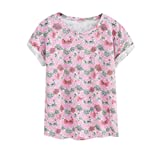

Product Title:  kawaii pastel tops tees pink flower design 
Euclidean Distance from input image: 47.38248
Amazon Url: www.amzon.com/dp/B071FCWD97


In [92]:
#load the features and corresponding ASINS info.
bottleneck_features_train = np.load('16k_data_cnn_features.npy')
asins = np.load('16k_data_cnn_feature_asins.npy')
asins = list(asins)

# load the original 16K dataset
data = pd.read_pickle('pickels/16k_apperal_data_preprocessed')
df_asins = list(data['asin'])


from IPython.display import display, Image, SVG, Math, YouTubeVideo


#get similar products using CNN features (VGG-16)
def get_similar_products_cnn(doc_id, num_results):
    doc_id = asins.index(df_asins[doc_id])
    pairwise_dist = pairwise_distances(bottleneck_features_train, bottleneck_features_train[doc_id].reshape(1,-1))

    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]
    sum = 0
    
    for i in range(len(indices)):
        rows = data[['medium_image_url','title']].loc[data['asin']==asins[indices[i]]]
        for indx, row in rows.iterrows():
            sum = sum + pdists[i]
#             display(Image(url=row['medium_image_url'], embed=True))
#             print('Product Title: ', row['title'])
#             print('Euclidean Distance from input image:', pdists[i])
#             print('Amazon Url: www.amzon.com/dp/'+ asins[indices[i]])

    return (sum/4)

get_similar_products_cnn(12566, 5)


In [65]:
import random
#Generate 5 random numbers between 10 and 30
randomlist = random.sample(range(0,16000), 2000)

len(randomlist)


2000

In [ ]:
x = np.ones((2000,6))
for i,val in enumerate(randomlist):

    x[i,0] = bag_of_words_model(val,5)
    x[i,1] = tfidf_model(val,5)
    x[i,2] = idf_model(val,5)
    x[i,3] = avg_w2v_model(val,5)
    x[i,4] = weighted_w2v_model(val,5)
    x[i,5] = get_similar_products_cnn(val, 5)



In [ ]:
print (np.mean(x, axis = 0))